### Relatório Preliminar - Matheus Freitas Sant'Ana

In [148]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [149]:
import subprocess
import time
import os
import sys
import matplotlib.pyplot as plt
import random
import statistics
import numpy as np
import pandas as pd


### Função para rodar executável e calcular tempo

In [150]:
def roda_com_entrada(executavel, arquivo_in):
    with open(arquivo_in) as f:
        start = time.perf_counter()
        proc = subprocess.run([executavel], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()

        # print('Saída:', proc.stdout)
        # print('Stderr:', proc.stderr)
        # print('Tempo total(s):', end - start)
        f.close()
    return (proc.stdout, end - start)

### Gerando arquivos de entrada

Aqui são gerados alguns arquivos de entrada com que vão progressivamente aumentando, para que sejam medidos a performance de cada heurística com entradas diferentes. A função `gerador_entrada_BE` é para o caso da Busca Exaustiva, em que a dinâmica de criar diversos arquivos de entrada para um mesmo n e obter a média é abdicada devido à alta complexidade do código.

In [151]:
def gerador_entrada(n, m):
    for i in range(0, 10):
        f = open(f'./inputs/in-{i}.txt', 'w')
        seq=[str(n)+'\n',
            str(m)+'\n',
            ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
            ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
    f.close()       

In [152]:
def gerador_entrada_BE(n, m, i):
    f = open(f'./inputs/in-{i}.txt', 'w')
    seq=[str(n)+'\n',
        str(m)+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
        ''.join(random.choices(['A','T','C','G','-'],k=m))]
    f.writelines(seq)
    f.close() 

#### Observações gerais

- Foram utilizados vetores para declarações de variáveis que possivelmente poderiam estourar a memória, como a matriz H que para `n`s e `m`s muito grandes uma linha como `int H[n][m]` pode não funcionar.

- Não será citado em todos os valgrinds, mas sempre que houve uma chamada à cin, isso sobrecarregou o programa. Além disso, alocações de grandes pedaços de memória como a da matriz H, também causou um alto número de instruções.

#### Heurística SmithWaterman

Essa primeira heurística leva em conta a construção de um amatriz de deslocamentos em que o score de cada célula tem um cálculo e um movimento, sendo que o algoritmo consiste basicamente de pegar a célula de maior score e "reconstruir" seu caminho até que um zero seja encontrado ou até que a matriz acabe, atribuindo pesos ao `match`, em caso de correspondência de sequências; `mismatch`, em caso de não-correspondência; e `gap`, caso haja um gap. Para esse projeto, esses valores foram determinados em 2, -1, -1, para match, mismatch e gap, respectivamente. 

Sendo assim, a estratégia adotada foi a de gerar múltiplas entradas com um mesmo tamanho, de tal forma que o cálculo seja rodado diversas vezes para cada n e que se obtenha uma média dos tempos obtidos e por consequência adquirindo um resultado mais confiável. Isso também foi repetido para a heurística de busca local (aleatorização).

A cada iteração, os tamanhos das sequêNicas geradas aleatoriamente são aumentados. No caso do algoritmo SmithWaterman, esse valor precisou ser muito alto, pois para valores baixos não é possível notar muitas diferenças de desempenho. Dito isso, o código é rodado 60 vezes com cada iteração o tamanho é aumentado. 

In [202]:
tamanhos_SW = []
media_tempo_SW = []

n = 10
m = 10

for i in range(0, 60):
    tempos_SW = []
    gerador_entrada(n, m)

    for i in range(0, 10):
        tempos_SW.append(roda_com_entrada('./SmithWaterman', f'./inputs/in-{i}.txt')[1])
    
    tamanhos_SW.append(n)
    media_tempo_SW.append(statistics.mean(tempos_SW))
    

    n += 10
    m += 10 

Text(0.5, 1.0, 'Heurística Smith Waterman')

Text(0.5, 0, 'Tamanhos')

Text(0, 0.5, 'Tempos')

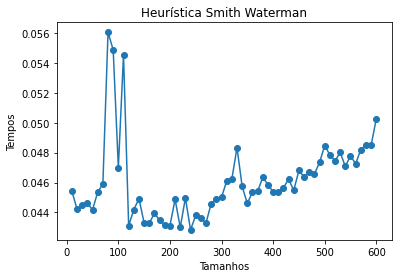

In [203]:
plt.scatter(tamanhos_SW, media_tempo_SW)
plt.plot(tamanhos_SW, media_tempo_SW)
plt.title('Heurística Smith Waterman')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.show()

Pode-se observar que conforme o tamanho aumenta, há um maior consumo de tempo, e que a distribuição de cada ponto se assemelha um pouo à uma reta linear. Há um pico no tempo na faixa de valores de `n` 100, o que pode ser explicado por talvez outros processos estarem rodando no computador que podem ter afetado a performance. No entanto, observa que essa diferença de tempo para n maiores não é tão significativa assim, o que faz sentido pois o código roda 'apenas' uma vez, ou seja, constroi a matriz apenas uma vez. 

Agora, utilizando a ferramenta do valgrind, observa-se que o código tem uma alta carga de instruções nos seguintes trechos:

```
.      // Inicializar matriz com 0s.
   413      for(int i = 0; i < n; i++) {
41,107          for(int j = 0; j < m; j++) {
10,504              H[i][j] = 0;
     .          }
     .      }
```

Nesse trecho, há uma alta complexidade de código devido aos dois loops aninhados, e como há uma escrita na matriz toda vez, isso acaba sobrecarregando o programa.

```
.      // 3. Para cada 1≤i≤n e 1≤j≤m:
   504      for(int i = 1; i < n; i++) {
41,000          for(int j = 1; j < m; j++) {
     .              // Calculando score w
     .              int w;
     .  
     .              if(a[i] == b[j]) {
     .                  // match
     .                  w = 2;
     .              } else {
     .                  // mismatch ou gap
70,000                  w = -1;
     .              }
    ```

Aqui, houve uma alta chamada também do mismatch ou gap, indicando que essa sequência teve mais mismatchs e gaps do que matches.

#### Heurística Aleatorização

Uma outra heurística é a de busca local, que consiste em basicamente adicionar aleatoridade às soluções da heurística anterior. Com isso, existem novos parâmetros `k`, que consiste no tamanho de cada subsequência que irá ser gerada, e o `p`, que representa a quantidade de subsequências geradas de uma das duas sequências. Esses parâmetros foram aleatorizados, e alguns fenômenos interessantes foram observados. 

Para o parâmetro `k`, foi observado que valores baixos de `k` implicam em scores menores de maneira geral. Para tamanhos de sequências menores, isso pode nao ser verdade, visto que às vezes um tamanho pequeno de subsequência como 3, pode ter o mesmo score de uma de 7. No entanto, essa disparidade é maior notada com tamanhos maiores. A maneira como é aleatorizado é pegando um número aleatório entre 0 e o tamanho da menor subsequência. Isso também determina os parâmtros de índice `i` e `j`, que representam o índice inicial de cada substring, A e B, que poderam ter um range de zero até um máximo `k - <tamanho_sequêcia>`. 

 Já o parâmetro `p` é aleatorizado também. Ele tem um range de 1 até um valor máximo que se baseia no tamanho da maior sequência. Ou seja, é proporcional ao tamanho da sequência e representa o número de subsequências que irão ser geradas. é importante encontrar um equilíbrio entre `k` e `p`, pois foi observado que para `k`s grandes, um tamanho menor de `p` era interessante, pois não há muitas possibilidades de subsequências. No entanto, quando o k é pequeno, é interessante ter um p maior, pois assim é possível gerar mais subsequências e por consequência uma maior possibilidade de obter o score máximo.

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400] [3.125368500011973, 3.087517600011779, 3.1274163000052795, 3.0612948999914806, 3.1625346000073478, 3.1826456999988295, 3.0946468000183813, 3.075638899987098, 3.117784100002609, 3.1146990999986883]


Text(0.5, 1.0, 'Heurística Aleatorização')

Text(0.5, 0, 'Tamanhos')

Text(0, 0.5, 'Tempos')

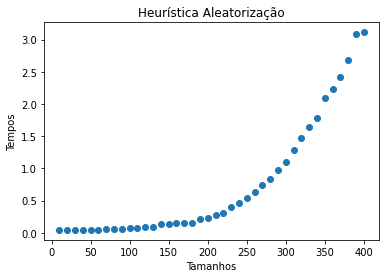

In [204]:
tamanhos_AL = []
media_tempo_AL = []

n = 10
m = 10

for i in range(0, 40):
    tempos_AL = []
    gerador_entrada(n, m)

    for i in range(0, 10):
        tempos_AL.append(roda_com_entrada('./Aleatorizacao', f'./inputs/in-{i}.txt')[1])
    
    tamanhos_AL.append(n)
    media_tempo_AL.append(statistics.mean(tempos_AL))
    

    n += 10
    m += 10

print(tamanhos_AL, tempos_AL)
plt.scatter(tamanhos_AL, media_tempo_AL)
plt.title('Heurística Aleatorização')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.show()

Já com a aleatorização, em compensação, foi observado um comportamento mais similar à de uma exponencial. Ou seja, quanto maior o n, pior o desempenho dessa heurística (e esse pior desempenho é mais notável do que na heurística SmithWaterman). Além disso, nota-se que o tempo foi muito maior nessa heurística, com o maiorr valor de n demorando próximo a 3 segundos, enquanto que na de SmithWaterman esse valor é de 0,05 segundos.

```
    280,538          for(int i = 0; i < n; i++) {
   610,960              for(int j = 0; j < m; j++) {
 4,609,434  => ???:0x0000000000109220 (122,192x)
        60                  H[i][j] = 0;
         .              }
         .          }
```

Os dois loops novamente mostram um altíssimo número de chamadas.

```
    10,388      for(int iter = 0; iter < p; iter++) {
         .          i = distribution_i(generator);
         .          // cout << endl << "i: " << i << endl;
     2,587          sa = a.substr(i, k);
         .          // cout << "sa: " << sa << endl;
    ```

Além disso, o novo loop de geração de cada subsequência de A é causa um alto número de chamada de instruções.

#### Busca Exaustiva

Essa heurística tem como principal objetivo levantar todas as possibilidades possíveis de subsequências e escolher o melhor resultado delas. Ou seja, obtem a **solução ótima global**. Duas estratégias diferentes foram utilizadadas para o cálculo dos scores, sendo a primeira a do SmithWaterman que consiste na construção da matriz, e a segunda será explicada mais a frente. Espera-se que, apesar de ter um score ótimo, já que encontra a melhor solução, mas em compensação esse algoritmo não consegue rodar para as entradas das heurísticas do SmithWaterman e da Aleatorização.

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43] [77.7139853000117]


Text(0.5, 1.0, 'Heurística Busca Exaustiva')

Text(0.5, 0, 'Tamanhos')

Text(0, 0.5, 'Tempos')

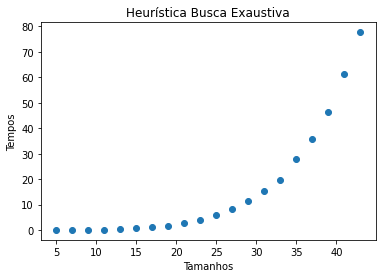

In [207]:
tamanhos_BE = []
media_tempo_BE = []

n = 5
m = 5

for i in range(0, 20):
    tempos_BE = []
    gerador_entrada_BE(n, m, i)
    
    tempos_BE.append(roda_com_entrada('./BuscaExaustiva', f'./inputs/in-{i}.txt')[1])
    
    tamanhos_BE.append(n)
    media_tempo_BE.append(statistics.mean(tempos_BE))
    

    n += 2
    m += 2

print(tamanhos_BE, tempos_BE)
plt.scatter(tamanhos_BE, media_tempo_BE)
plt.title('Heurística Busca Exaustiva')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.show()

O gráfico possui um formato similar à heurística de aleatorização, mas o tempo é muito maior, mesmo com tamanhos menores. Descobriu-se que o tamanho máximo antes de não rodar mais o código era algo em torno de 60 para n e m. O tempo já é muito alto para tamanhos muito grandes, excedendo até 1 minuto em alguns casos.

```
    1      int seed = 13607;
        20      for(int i = 0; i < 10; i++) {
     2,290          for(uint i = 0; i < a_combinations.size(); i++) {
   122,100              for(uint j = 0; j < b_combinations.size(); j++) {
    90,750                  n = a_combinations[i].size();
    60,500                  m = b_combinations[j].size();
         .  
         .                  result alignment;
   211,750                  alignment = algorithmLocalAlignment(n, m, a_combinations[i], b_combinations[j], seed);
1,101,528,035  => BuscaExaustiva.cpp:algorithmLocalAlignment(int, int, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, unsigned int) (30,250x)
         .  
    90,750                  if(alignment.score > bestResult.score) {
         .                      bestResult = alignment;
         .                  }
    30,250                  seed++;
         .              }
         .          }
         .      }
 ```

Além dos mesmos trechos dos anteriores,  agora essa parte possui um maior número de chamadas à `algorithmLocalAlignment`, causando um alto número de instruções. Cada chamada dessa função envolve todo o cálculo da matriz H, e como é a heurística aleatorizada que está sendo calculada, há também o for das `p`s subsequências que estão sendo geradas. Depois disso, é necessário também sempre comparar com o melhor resultado e finalmente retornar, tudo isso acarretando em uma das maiores complexidades e número de instruções de código.

#### Busca Exaustiva Truncado

Essa estratégia foi escolhida visando uma diminuição no tempo total de consumo, porém ainda utilizando a estratégia de Busca Exaustiva. Consiste basicamente em redimensionar a maior subsequência para o tamanho da menor, e calcular o score desse par de subsequências escolhendo o melhor. 

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43] [0.777910199976759]


Text(0.5, 1.0, 'Heurística Busca Exaustiva Truncado')

Text(0.5, 0, 'Tamanhos')

Text(0, 0.5, 'Tempos')

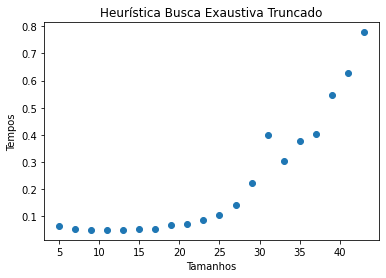

In [208]:
tamanhos_BT = []
media_tempo_BT = []

n = 5
m = 5

for i in range(0, 20):
    tempos_BT = []
    gerador_entrada_BE(n, m, i)
    
    tempos_BT.append(roda_com_entrada('./BuscaExaustivaTruncado', f'./inputs/in-{i}.txt')[1])
    
    tamanhos_BT.append(n)
    media_tempo_BT.append(statistics.mean(tempos_BT))
    

    n += 2
    m += 2

print(tamanhos_BT, tempos_BT)
plt.scatter(tamanhos_BT, media_tempo_BT)
plt.title('Heurística Busca Exaustiva Truncado')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.show()

Observando o gráfico, pode-se verificar que ele possui um formato similar ao da primeira estratégia de busca exaustiva, e também um menor tempo. Como parte de cada subsequência é sacrificada, espera-se que seu desempenho seja menor em relação ao original, o que irá ser confirmado na próxima seção.

Esse código não é muito pesado, pois não há loops que chamam funções complexas de cálculos. Ele apenas faz um simples cálculo e sacrifica parte da string de uma das subsequências para facilitar o cálculo. A parte mais pesada desse código são os cins, similarmente às heurísticas anteriores.

#### Comparação desempenho

Agora que todos os gráficos individuais foram gerados, para efeito de comparação serão gerados rodadas todas as heurísticas para 3 inputs diferentes, e observar se houve diferença de desempenho apenas ( a métrica do tempo já foi analisada anteriormente)

In [211]:
n = 5
m = 5
df_results = pd.DataFrame()
index = []

for i in range(0, 3):
    gerador_entrada_BE(n, m, i)
    with open(f'./inputs/in-{i}.txt') as f:
        
        proc_SW = roda_com_entrada('./SmithWaterman', f'./inputs/in-{i}.txt')[0]
        proc_AL = roda_com_entrada('./Aleatorizacao', f'./inputs/in-{i}.txt')[0]
        proc_BE = roda_com_entrada('./BuscaExaustiva', f'./inputs/in-{i}.txt')[0]
        proc_BT = roda_com_entrada('./BuscaExaustivaTruncado', f'./inputs/in-{i}.txt')[0]

        # print(f'Arquivo in-{i}.txt')
        # print(proc_SW)
        # print(proc_AL)
        # print(proc_BE)
        # print(proc_BT)

        list_SW = proc_SW.splitlines()
        index.append('SmithWaterman ')
        list_AL = proc_AL.splitlines()
        index.append('Aleatorizacao ')
        list_BE = proc_BE.splitlines()
        index.append('BuscaExaustiva')
        list_BT = proc_BT.splitlines()
        index.append('ExaustivaTrunc')


        df_results = df_results.append({'n': n,
                           'm': m,
                           'score': list_SW[0],
                           'subsequência A': list_SW[1],
                           'subsequência B': list_SW[2],
                           }, ignore_index=True)
        df_results = df_results.append({'n': n,
                           'm': m,
                           'score': list_AL[0],
                           'subsequência A': list_AL[1],
                           'subsequência B': list_AL[2],
                           }, ignore_index=True)
        df_results = df_results.append({'n': n,
                           'm': m,
                           'score': list_BE[0],
                           'subsequência A': list_BE[1],
                           'subsequência B': list_BE[2],
                           }, ignore_index=True)
        df_results = df_results.append({'n': n,
                           'm': m,
                           'score': list_BT[0],
                           'subsequência A': list_BT[1],
                           'subsequência B': list_BT[2],
                           }, ignore_index=True)
        df_results.index = index
    
    n += 25
    m += 25

/tmp/ipykernel_9135/3780873345.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'n': n,
/tmp/ipykernel_9135/3780873345.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'n': n,
/tmp/ipykernel_9135/3780873345.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'n': n,
/tmp/ipykernel_9135/3780873345.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'n': n,
/tmp/ipykernel_9135/3780873345.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

Gerando a tabela de comparação de resultados:

In [213]:
df_results

,n,m,score,subsequência A,subsequência B
SmithWaterman,5,5,Melhor Resultado: 4,TG,TG
Aleatorizacao,5,5,Melhor resultado: 4,--TGTA,-CTTG-
BuscaExaustiva,5,5,Melhor resultado: 4,TG,TG
ExaustivaTrunc,5,5,Melhor resultado: 4,TG,TG
SmithWaterman,30,30,Melhor Resultado: 16,A-_G_GGA-_--G-GA--ACTAA--C,A-CG-GGG-CC-_TGT--__TTAG-C
Aleatorizacao,30,30,Melhor resultado: 16,--GGGA---G-GA--ACTAA--C-AT-,-A-A-CG-GGG-CC-TGT--TTAG-CC
BuscaExaustiva,30,30,Melhor resultado: 16,-GGGA---G-GA--ACTAA--C,-GGG-CC-TGT--TTAG-CCGT
ExaustivaTrunc,30,30,Melhor resultado: 8,-GGG,-GGG
SmithWaterman,55,55,Melhor Resultado: 29,TGAGTT-AG-C_-GGAA_C_TA_T--A-G-__CTT-_GGA,TG_GTT_ACACG-GCAA-CTTACGAAA-G-TAC_T-CGCA
Aleatorizacao,55,55,Melhor resultado: 28,-TGAGTT-AG-C-GGAACTAT--A-G-CTT-GGATCTGTC-GGGTG...,-CT-GTAA-AGG--ATACATGGTTACACG-GCAA-CTTACGAAA-G...


Apesar de ser uma tabela com apenas 3 valores, já é possível observar algumas coisas interessantes. Em questão de scores, como os n são pequenos, os resultados são quase iguais para todos. Apenas para a heurística da exaustiva truncado que otemos um desempenho inferior sempre, o que foi hipotetizado antes já que parte da string é jogada fora toda vez e também não são testadas diferentes formas de alinhamento, prejudicando o desempenho. Além disso, já é possível observar também que a heurística de aleatorização às vezes possui um desempenho ruim em n pequenos. Isso porque como há aleatorização, pode ser que `k`s pequenos sejam escolhidos e portanto scores baixos sejam obtidos. No entanto, para n maiores isso não deve acontecer.

Gerando o gráfico com todas as heurísticas e seus respectivos inputs:

Text(0.5, 1.0, 'Todas as heurísticas')

Text(0.5, 0, 'Tamanhos')

Text(0, 0.5, 'Tempos')

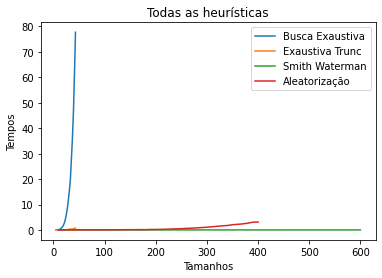

In [216]:
plt.plot(tamanhos_BE, media_tempo_BE, label='Busca Exaustiva')
plt.plot(tamanhos_BT, media_tempo_BT, label='Exaustiva Trunc')
plt.plot(tamanhos_SW, media_tempo_SW, label='Smith Waterman')
plt.plot(tamanhos_AL, media_tempo_AL, label='Aleatorização')
plt.title('Todas as heurísticas')
plt.xlabel('Tamanhos')
plt.ylabel('Tempos')
plt.legend()

Nesse gráfico, já é possível observar como o desempenho das buscas exaustivas é sensível ao n. Enquanto que a Smith Waterman e a de aleatorização aguentam para tamanhos de até 400. Para valores abaixo de 50 de n, já fica praticamente impossível de escalar a busca exaustiva. 

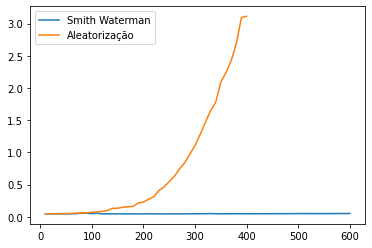

In [214]:
plt.plot(tamanhos_SW, media_tempo_SW, label='Smith Waterman')
plt.plot(tamanhos_AL, media_tempo_AL, label='Aleatorização')
plt.legend()

Analisando mais a fundo a aleatorização e o sith waterman, percebe- se que há uma disparidade de desempenho entre elas. Isso porque o de aleartorização roda diversas vezes, e com valores de `p` diferentes. Talve seja por isso que não se obtem uma reta perfeita e sim com perturbações. No entanto, como comentado anteriormente, os desempenhos começam a diferir para n grandes, com a heurística de aleatorização se sobressaindo quando o código é rodado diversas vezes. 